In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from mlxtend.classifier import StackingCVClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('kidney_urine_with_sugar.csv')

# Add an 'id' column (starting from 1)
df.insert(0, 'id', range(1, len(df) + 1))

# Save the updated dataset
df.to_csv('kidney_urine_with_id.csv', index=False)

print("✅ 'id' column added and new file saved as 'kidney_urine_with_id.csv'.")


✅ 'id' column added and new file saved as 'kidney_urine_with_id.csv'.


In [3]:
# Load the dataset
df = pd.read_csv('kidney_urine_with_id.csv')
# drop the 'id' column
df.drop('id', axis=1, inplace=True)

In [4]:
df.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target', 'sugar'], dtype='object')

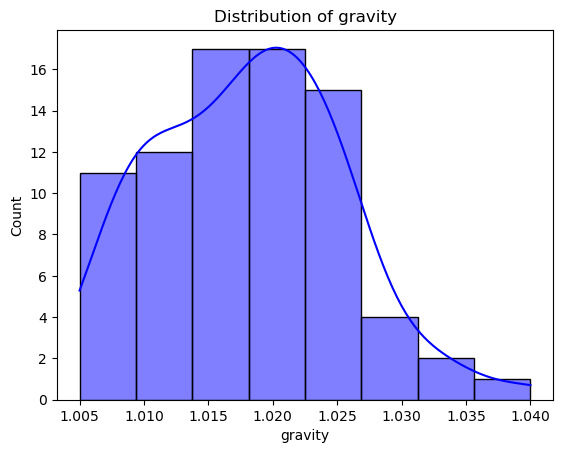

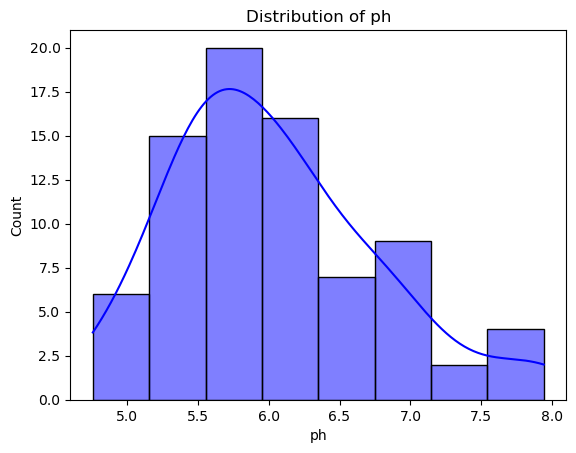

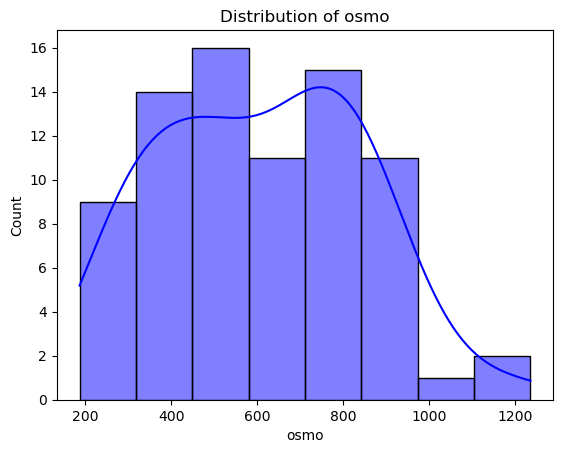

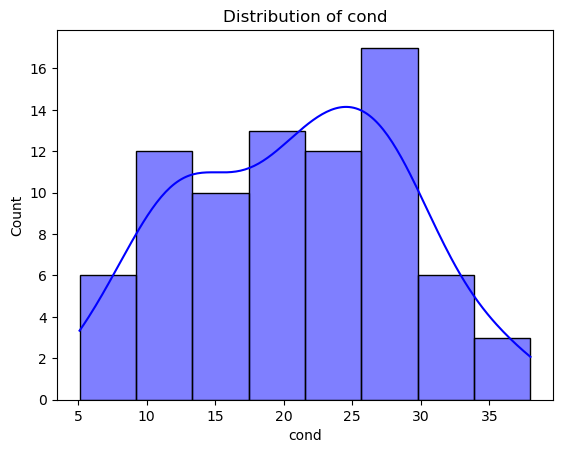

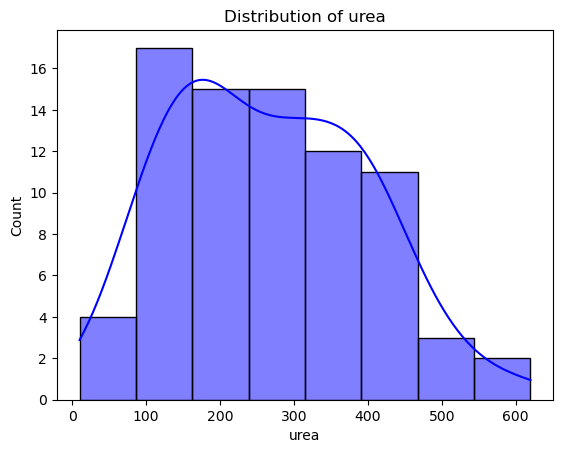

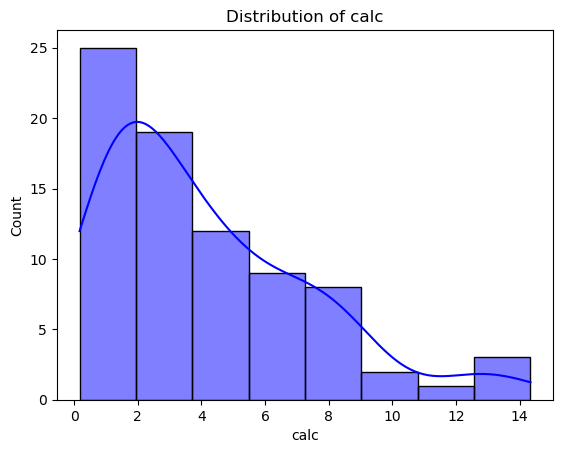

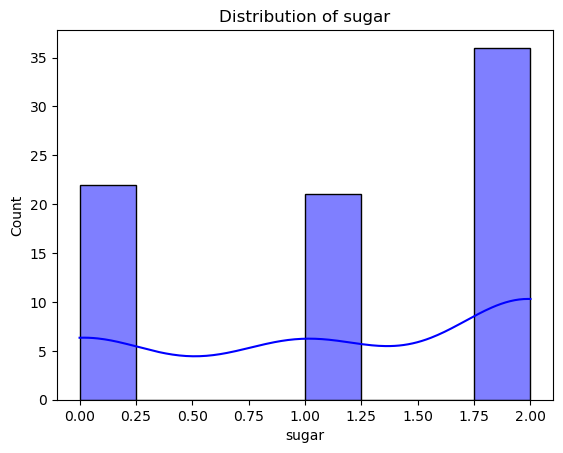

In [5]:
data_without_target = df.drop(columns=['target'])

# Distribution plots
for column in data_without_target.columns:
    plt.figure()
    sns.histplot(data=data_without_target, x=column, kde=True, color='blue')
    plt.title(f'Distribution of {column}')
    plt.show()

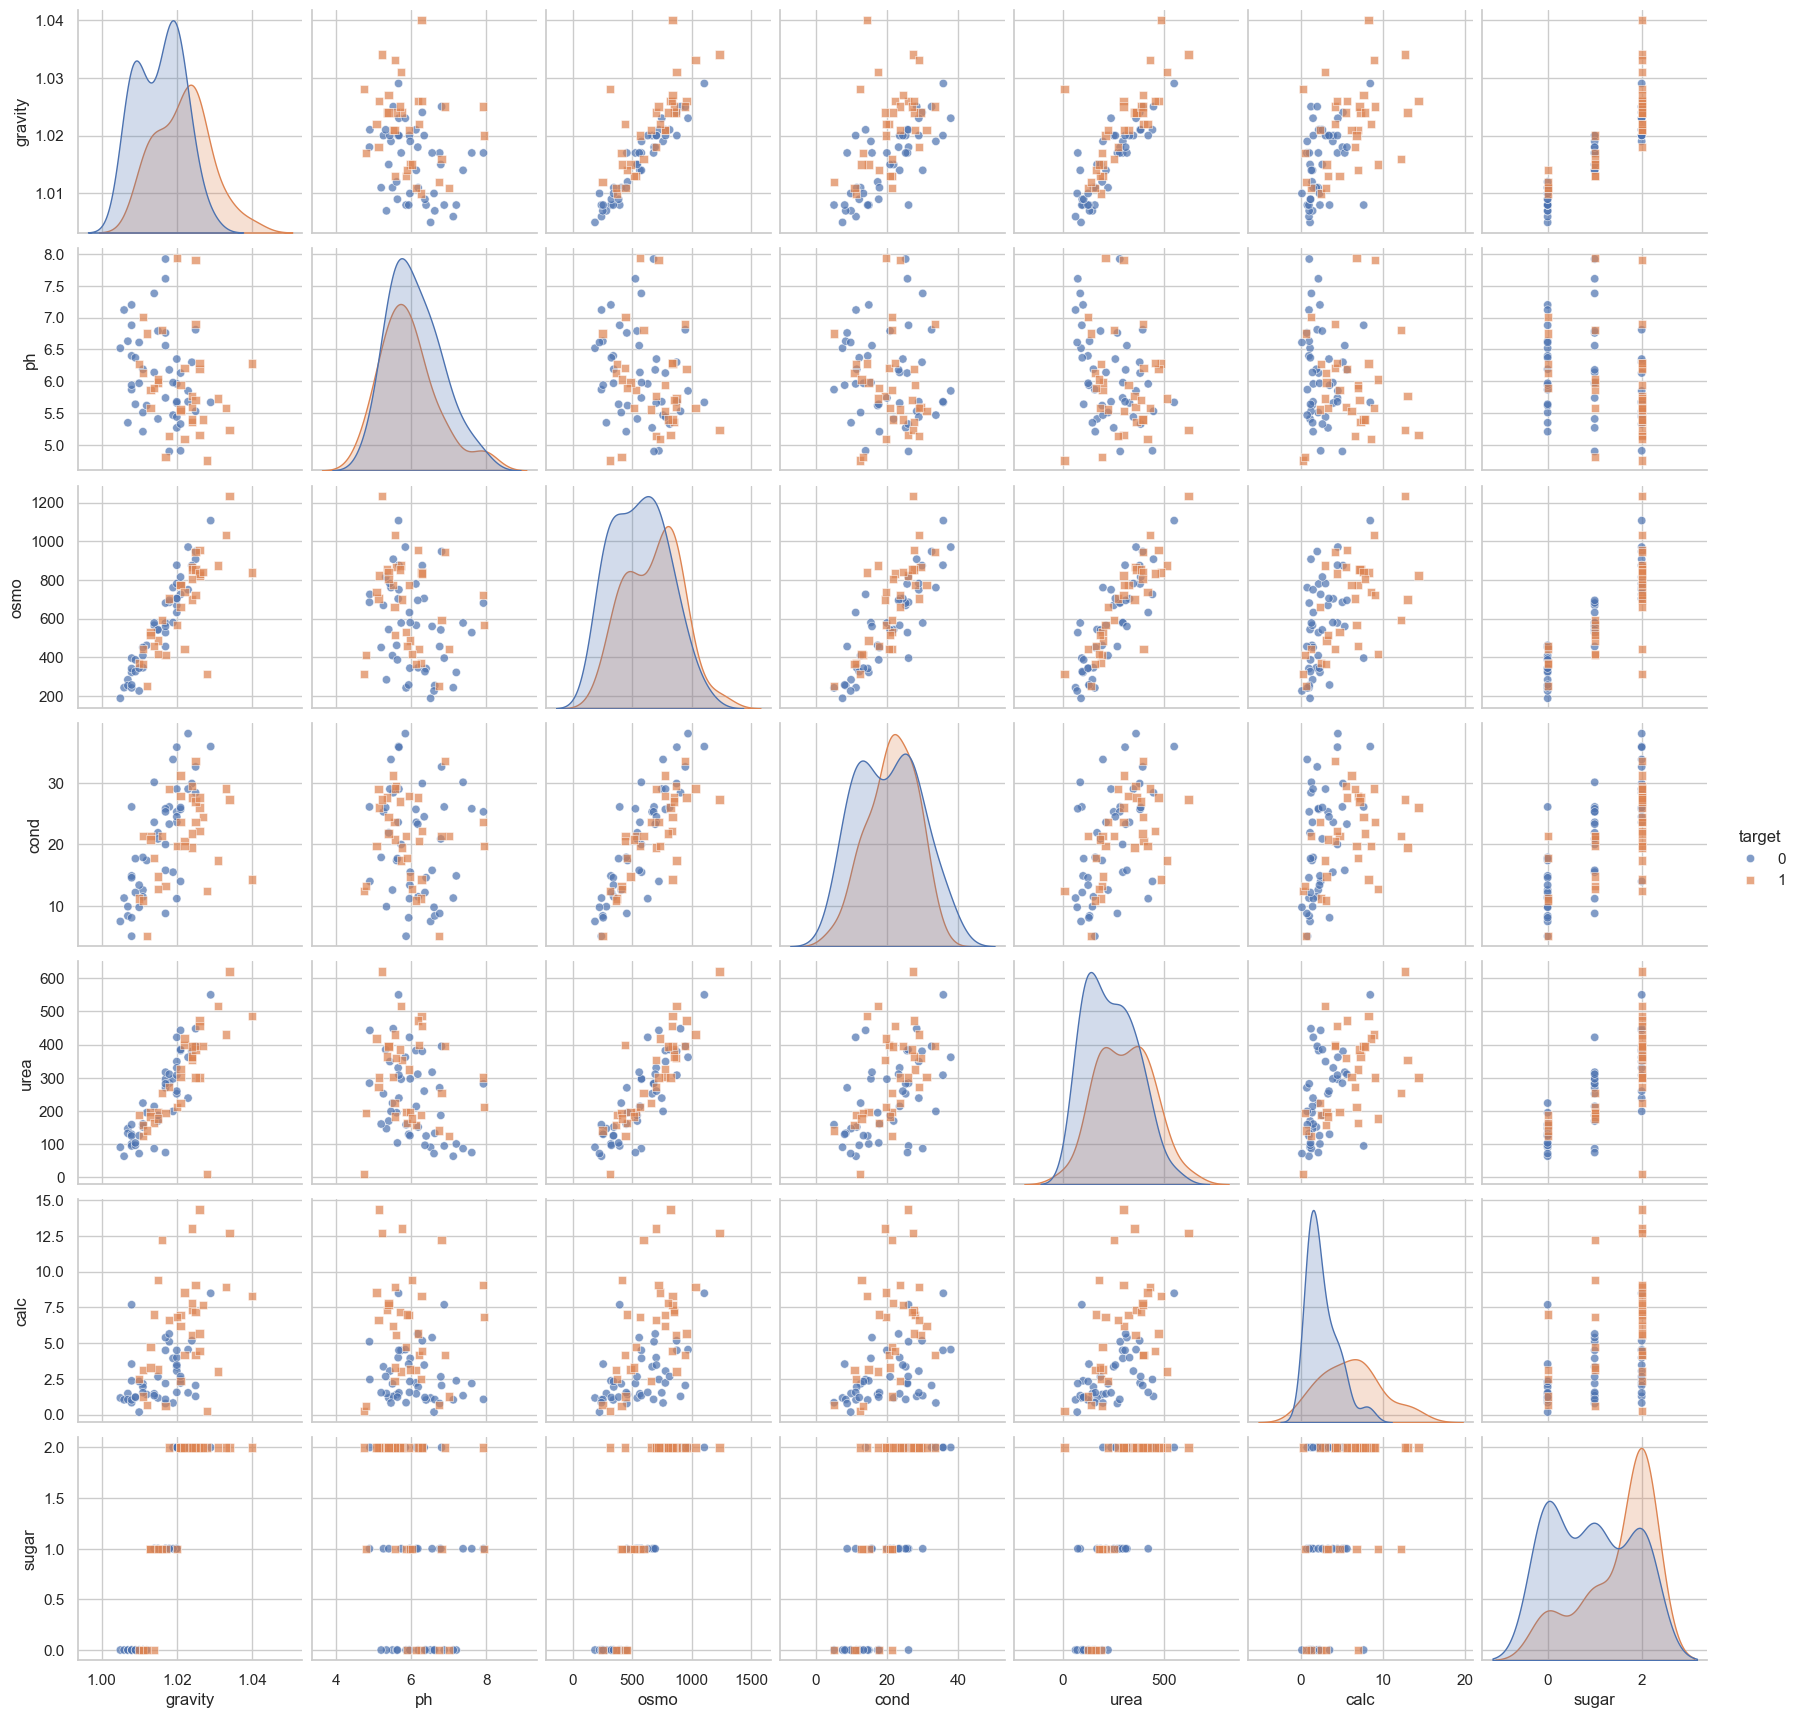

In [6]:
# Scatterplot matrix
sns.set(style='whitegrid')
sns.pairplot(df, hue='target', diag_kind='kde', markers=['o', 's'], plot_kws={'alpha': 0.7})
plt.show()

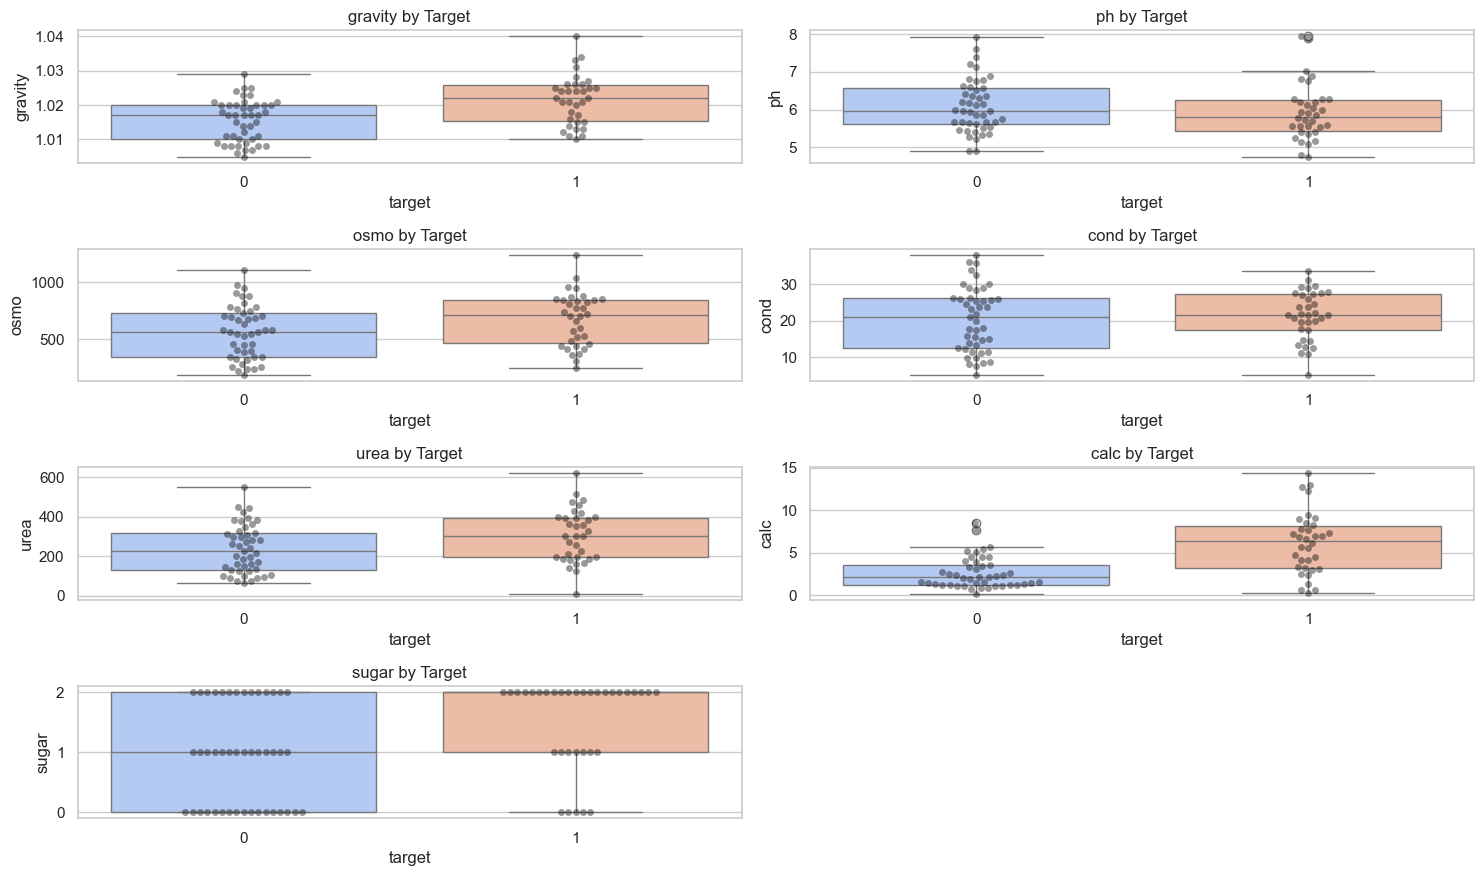

In [7]:
# Box plots and swarm plots
plt.figure(figsize=(15, 15))
for i, column in enumerate(data_without_target.columns):
    plt.subplot(len(data_without_target.columns), 2, i + 1)
    sns.boxplot(x='target', y=column, data=df, palette='coolwarm')
    sns.swarmplot(x='target', y=column, data=df, color='black', alpha=0.4)
    plt.title(f'{column} by Target')
plt.tight_layout()
plt.show()

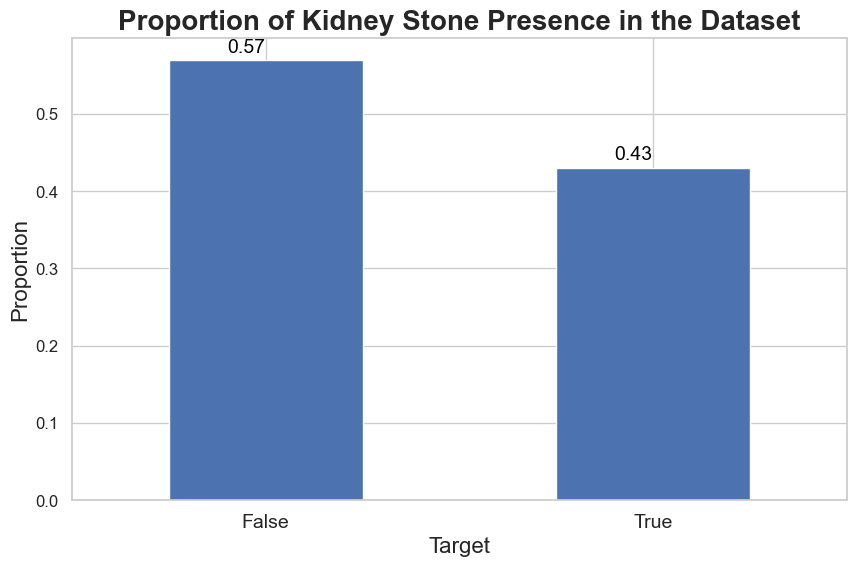

In [8]:
target_counts = df['target'].value_counts(normalize=True)

ax = target_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Target', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_title('Proportion of Kidney Stone Presence in the Dataset', fontsize=20, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0, fontsize=14)
plt.yticks(fontsize=12)

for i, v in enumerate(target_counts):
    ax.text(i - 0.1, v + 0.01, f'{v:.2f}', fontsize=14, color='black')

plt.show()

The dataset exhibits a slight class imbalance, with the majority class ('False') accounting for 56% and the minority class ('True') accounting for 44% of the total instances. While this is not a severe imbalance, it can still introduce bias in the model and impact its performance. To mitigate this issue, we can use the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class. By doing this, we can balance the class distribution and potentially improve the model's ability to generalize and make accurate predictions for both classes.

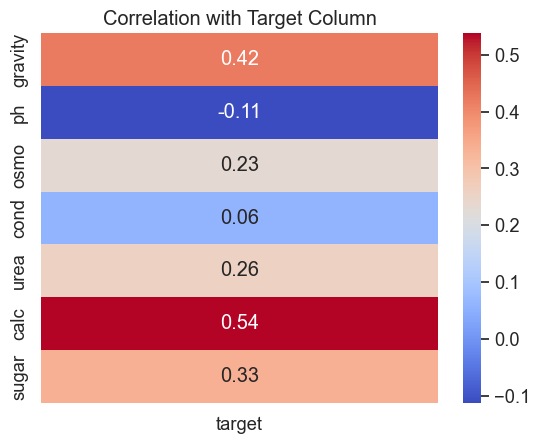

In [9]:
# compute the correlation matrix with the target column
corr = df.corr()

# extract the correlations with the target column
target_corr = corr['target'].drop('target')

# create a heatmap of the correlations with the target column
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Target Column')
plt.show()

Feature Engineering

1.Specific gravity to calcium ratio:

This feature can help understand how concentrated the calcium content is in the urine, which can potentially affect stone formation.

formula : specific_gravity_calcium_ratio = specific_gravity x calcium_concentration

2..Calcium to conductivity product:

This feature can help determine the proportion of calcium ions relative to the total ion content, which might impact stone formation risk.

formula : calcium_conductivity_product = calcium_concentration * conductivity

3..Calcium and pH product:

As the solubility of different types of kidney stones can be affected by pH, creating a product term between calcium concentration and pH could provide insight into the combined impact of these factors on kidney stone formation.

formula : calcium_pH_product = calcium_concentration * pH

4.Urea and pH product:

A high protein diet can increase the risk of kidney stone formation. Since urea is a waste product of protein metabolism, creating a product term between urea concentration and pH could help capture the combined effect of diet and urine acidity on stone formation risk.

formula : urea_pH_product = urea_concentration * pH

5.Osmolarity and calcium product:

A high osmolarity indicates concentrated urine, which could contribute to the formation of kidney stones. Creating a product term between osmolarity and calcium concentration might help capture the combined effect of urine concentration and calcium levels on stone formation risk.

formula : osmolarity_calcium_product = osmolarity * calcium_concentration

6.Estimated urine volume:

This feature estimates the urine volume based on specific gravity and osmolarity, which can provide insight into the concentration of solutes in the urine and their potential to form kidney stones.

formula: urine_volume = (1000 specific_gravity osmolarity) / (18 * 1.001)

In [10]:
# Calculate estimated urine volume
df['urine_volume'] = (1000 * df['gravity'] * df['osmo']) / (18 * 1.001)

# Specific gravity to calcium ratio
df['specific_gravity_calcium_ratio'] = df['gravity'] / df['calc']

# Calcium to conductivity product
df['calcium_conductivity_ratio'] = df['calc'] / df['cond']

# Calcium and pH product
df['calcium_pH_interaction'] = df['calc'] * df['ph']

# Urea and pH product
df['urea_pH_interaction'] = df['urea'] * df['ph']

# Osmolarity and calcium product
df['osmolarity_calcium_interaction'] = df['osmo'] * df['calc']

### **NEW: Sugar-Based Feature Calculations**
# Sugar-Specific Gravity Ratio
df['sugar_gravity_ratio'] = df['gravity'] / (df['sugar'] + 1)  # Avoid division by zero

# Sugar-Osmolality Interaction
df['sugar_osmo_interaction'] = df['osmo'] * df['sugar']

# Sugar-Conductivity Ratio
df['sugar_cond_ratio'] = df['cond'] / (df['sugar'] + 1)  # Avoid division by zero

# Sugar-pH Product
df['sugar_pH_product'] = df['sugar'] * df['ph']

# Sugar-Urea Interaction
df['sugar_urea_interaction'] = df['sugar'] * df['urea']

### **NEW: Sugar Interpretation**
df['sugar_interpretation'] = df['sugar'].map({
    0: 'Low Sugar - Normal',
    1: 'Medium Sugar - Possible Hyperglycemia',
    2: 'High Sugar - Potential Diabetes Risk'
})

# Display first few rows
df.head()


,gravity,ph,osmo,cond,urea,calc,target,sugar,urine_volume,specific_gravity_calcium_ratio,calcium_conductivity_ratio,calcium_pH_interaction,urea_pH_interaction,osmolarity_calcium_interaction,sugar_gravity_ratio,sugar_osmo_interaction,sugar_cond_ratio,sugar_pH_product,sugar_urea_interaction,sugar_interpretation
0,1.021,4.91,725,14.0,443,2.45,0,2,41082.528583,0.416735,0.175000,12.0295,2175.13,1776.25,0.340333,1450,4.666667,9.82,886,High Sugar - Potential Diabetes Risk
1,1.017,5.74,577,20.0,296,4.49,0,1,32567.932068,0.226503,0.224500,25.7726,1699.04,2590.73,0.508500,577,10.000000,5.74,296,Medium Sugar - Possible Hyperglycemia
2,1.008,7.20,321,14.9,101,2.36,0,0,17958.041958,0.427119,0.158389,16.9920,727.20,757.56,1.008000,0,14.900000,0.00,0,Low Sugar - Normal
3,1.011,5.51,408,12.6,224,2.15,0,0,22893.106893,0.470233,0.170635,11.8465,1234.24,877.20,1.011000,0,12.600000,0.00,0,Low Sugar - Normal
4,1.005,6.52,187,7.5,91,1.16,0,0,10430.402930,0.866379,0.154667,7.5632,593.32,216.92,1.005000,0,7.500000,0.00,0,Low Sugar - Normal


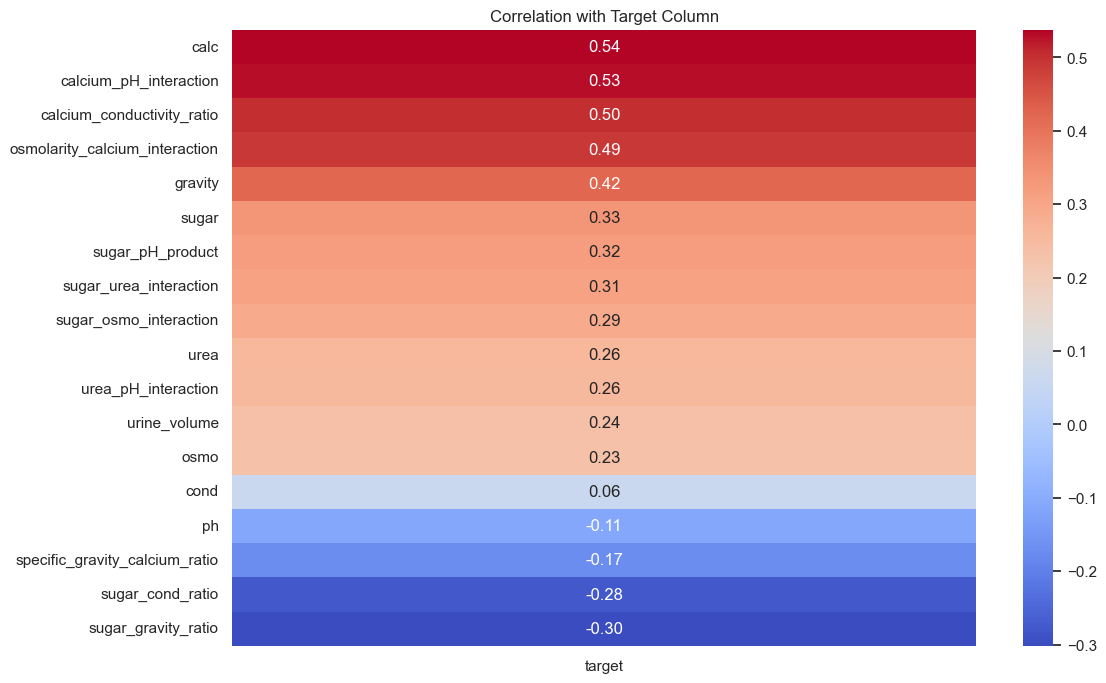

In [12]:
# Drop non-numeric columns before correlation
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns

# Compute correlation matrix
corr = numeric_df.corr()

# Sort correlation with target
target_corr = corr['target'].drop('target').sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Target Column')
plt.show()


In [20]:
# Ensure only numeric columns are used
X = df.select_dtypes(include=['number']).drop(columns=['target'])
y = df['target']  

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Show accuracy
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

# Check feature importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)


Accuracy: 0.6875
Classification Report:               precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.50      0.40      0.44         5

    accuracy                           0.69        16
   macro avg       0.62      0.61      0.61        16
weighted avg       0.67      0.69      0.68        16

Confusion Matrix: [[9 2]
 [3 2]]
                           Feature  Importance
9       calcium_conductivity_ratio    0.154254
5                             calc    0.126486
10          calcium_pH_interaction    0.111023
15                sugar_cond_ratio    0.098873
8   specific_gravity_calcium_ratio    0.098501
12  osmolarity_calcium_interaction    0.057378
11             urea_pH_interaction    0.046548
13             sugar_gravity_ratio    0.041633
0                          gravity    0.036033
3                             cond    0.036029
2                             osmo    0.033717
1                               ph  

In [22]:
import pandas as pd

# Ensure model is trained
rf = RandomForestClassifier()  # Replace with your model
rf.fit(X_train, y_train)  # Train the model

# Extract feature importance
feature_importance = rf.feature_importances_  # Works for tree-based models

# Create DataFrame with feature names and importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importance
})

# Sort and select top features
num_features = 5  # Choose based on experimentation
selected_features = feature_importance_df.nlargest(num_features, 'Importance')['Feature'].values

# Create a new DataFrame with only selected features
X_top = X[selected_features]

print("Selected Features:", selected_features)


Selected Features: ['calcium_conductivity_ratio' 'calcium_pH_interaction' 'sugar_cond_ratio'
 'calc' 'specific_gravity_calcium_ratio']


In [24]:
# Data Preprocessing

# Handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X[selected_features], y)

# Use SMOTE-resampled data for training
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [25]:
# Prediction Model (Regression)
models = [
    ('LogisticRegression', LogisticRegression(max_iter=10000, random_state=42)),
    ('SVC', SVC(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42)),
    ('LightGBM', lgb.LGBMClassifier(random_state=42)),
    ('CatBoost', cb.CatBoostClassifier(random_state=42, verbose=0))
]

# Train and evaluate the models
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} accuracy: {accuracy:.4f}")

LogisticRegression accuracy: 0.6667
SVC accuracy: 0.6111
RandomForestClassifier accuracy: 0.8333
GradientBoostingClassifier accuracy: 0.8333
XGBoost accuracy: 0.5556
[LightGBM] [Info] Number of positive: 39, number of negative: 33
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541667 -> initscore=0.167054
[LightGBM] [Info] Start training from score 0.167054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [27]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# ✅ Define base classifiers
lr = LogisticRegression()
svc = SVC(probability=True)  # Ensure probability=True for stacking
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
mlp = MLPClassifier(max_iter=500, random_state=42)  # Ensure it trains well

# ✅ Define meta-model
meta_model = LogisticRegression()

# ✅ Define stacking classifier
stacking_classifier = StackingClassifier(
    estimators=[('lr', lr), ('svc', svc), ('rf', rf), ('gbc', gbc), ('mlp', mlp)],
    final_estimator=meta_model
)

# Fit the model
stacking_classifier.fit(X_train_scaled, y_train)

# Predictions
y_val_pred = stacking_classifier.predict(X_val_scaled)

# Accuracy
stacking_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Stacking Classifier accuracy: {stacking_accuracy:.4f}")


Stacking Classifier accuracy: 0.8333


In [30]:
def create_nn_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),  # More neurons
        layers.BatchNormalization(),  # Normalize activations
        layers.Dropout(0.3),  # Prevent overfitting
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [31]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)  # Slower, more stable learning


In [38]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

nn_history = nn_model.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
    epochs=300, batch_size=32, verbose=1, callbacks=[early_stop]
)


Epoch 1/300
3/3 [==============================] - 0s 72ms/step - loss: 0.4037 - accuracy: 0.7778 - val_loss: 0.6349 - val_accuracy: 0.6111
Epoch 2/300
3/3 [==============================] - 0s 31ms/step - loss: 0.3806 - accuracy: 0.7917 - val_loss: 0.6356 - val_accuracy: 0.6111
Epoch 3/300
3/3 [==============================] - 0s 32ms/step - loss: 0.3901 - accuracy: 0.7917 - val_loss: 0.6373 - val_accuracy: 0.6111
Epoch 4/300
3/3 [==============================] - 0s 31ms/step - loss: 0.3817 - accuracy: 0.8056 - val_loss: 0.6400 - val_accuracy: 0.6111
Epoch 5/300
3/3 [==============================] - 0s 32ms/step - loss: 0.3969 - accuracy: 0.7917 - val_loss: 0.6402 - val_accuracy: 0.6111
Epoch 6/300
3/3 [==============================] - 0s 30ms/step - loss: 0.4132 - accuracy: 0.7917 - val_loss: 0.6397 - val_accuracy: 0.6111
Epoch 7/300
3/3 [==============================] - 0s 30ms/step - loss: 0.4045 - accuracy: 0.8056 - val_loss: 0.6408 - val_accuracy: 0.6111
Epoch 8/300
3/3 [===

In [39]:
print(y_train.value_counts())


target
1    39
0    33
Name: count, dtype: int64


In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


In [42]:
# Get final training & validation accuracy
train_accuracy = nn_history.history['accuracy'][-1]  # Last epoch's training accuracy
val_accuracy = nn_history.history.get('val_accuracy', [None])[-1]  # Last epoch's validation accuracy

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Training Accuracy: 0.8056
Validation Accuracy: 0.6667


In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Create a SIMPLER neural network
def create_optimized_nn(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),  
        layers.BatchNormalization(),
        layers.Dropout(0.3),  
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='sigmoid')  
    ])
    
    optimizer = Adam(learning_rate=0.0005)  # ✅ Lower learning rate
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ✅ Train the optimized model
optimized_nn = create_optimized_nn(X_train_scaled.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5)

optimized_nn_history = optimized_nn.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
    epochs=300, batch_size=32, verbose=1,  # ✅ Larger batch size
    callbacks=[early_stopping, reduce_lr]
)

# ✅ Show accuracy
optimized_nn_accuracy = optimized_nn_history.history['val_accuracy'][-1]
print(f"Optimized Neural Network Accuracy: {optimized_nn_accuracy:.4f}")


Epoch 1/300
3/3 [==============================] - 2s 238ms/step - loss: 0.6496 - accuracy: 0.6667 - val_loss: 0.6452 - val_accuracy: 0.7222 - lr: 5.0000e-04
Epoch 2/300
3/3 [==============================] - 0s 29ms/step - loss: 0.6589 - accuracy: 0.6667 - val_loss: 0.6369 - val_accuracy: 0.7778 - lr: 5.0000e-04
Epoch 3/300
3/3 [==============================] - 0s 29ms/step - loss: 0.5959 - accuracy: 0.7222 - val_loss: 0.6317 - val_accuracy: 0.7778 - lr: 5.0000e-04
Epoch 4/300
3/3 [==============================] - 0s 36ms/step - loss: 0.4633 - accuracy: 0.8333 - val_loss: 0.6266 - val_accuracy: 0.7778 - lr: 5.0000e-04
Epoch 5/300
3/3 [==============================] - 0s 40ms/step - loss: 0.6002 - accuracy: 0.7639 - val_loss: 0.6227 - val_accuracy: 0.7222 - lr: 5.0000e-04
Epoch 6/300
3/3 [==============================] - 0s 33ms/step - loss: 0.5771 - accuracy: 0.7500 - val_loss: 0.6181 - val_accuracy: 0.7222 - lr: 5.0000e-04
Epoch 7/300
3/3 [==============================] - 0s 34m

In [49]:
# Load the test dataset
test_df = pd.read_csv('kidney_urine_with_id.csv')

In [50]:
# Calculate estimated urine volume
test_df['urine_volume'] = (1000 * test_df['gravity'] * test_df['osmo']) / (18 * 1.001)

# Specific gravity to calcium ratio
test_df['specific_gravity_calcium_ratio'] = test_df['gravity'] / test_df['calc']

# Calcium to conductivity product
test_df['calcium_conductivity_ratio'] = test_df['calc'] / test_df['cond']

# Calcium and pH product
test_df['calcium_pH_interaction'] = test_df['calc'] * test_df['ph']

# Urea and pH product
test_df['urea_pH_interaction'] = test_df['urea'] * test_df['ph']

# Osmolarity and calcium product
test_df['osmolarity_calcium_interaction'] = test_df['osmo'] * test_df['calc']

### **NEW: Sugar-Based Feature Calculations**
# Sugar-Specific Gravity Ratio
test_df['sugar_gravity_ratio'] = test_df['gravity'] / (test_df['sugar'] + 1)  # Avoid division by zero

# Sugar-Osmolality Interaction
test_df['sugar_osmo_interaction'] = test_df['osmo'] * test_df['sugar']

# Sugar-Conductivity Ratio
test_df['sugar_cond_ratio'] = test_df['cond'] / (test_df['sugar'] + 1)  # Avoid division by zero

# Sugar-pH Product
test_df['sugar_pH_product'] = test_df['sugar'] * test_df['ph']

# Sugar-Urea Interaction
test_df['sugar_urea_interaction'] = test_df['sugar'] * test_df['urea']

### **NEW: Sugar Interpretation**
test_df['sugar_interpretation'] = test_df['sugar'].map({
    0: 'Low Sugar - Normal',
    1: 'Medium Sugar - Possible Hyperglycemia',
    2: 'High Sugar - Potential Diabetes Risk'
})

# Display first few rows to verify
test_df.head()


,id,gravity,ph,osmo,cond,urea,calc,target,sugar,urine_volume,...,calcium_conductivity_ratio,calcium_pH_interaction,urea_pH_interaction,osmolarity_calcium_interaction,sugar_gravity_ratio,sugar_osmo_interaction,sugar_cond_ratio,sugar_pH_product,sugar_urea_interaction,sugar_interpretation
0,1,1.021,4.91,725,14.0,443,2.45,0,2,41082.528583,...,0.175000,12.0295,2175.13,1776.25,0.340333,1450,4.666667,9.82,886,High Sugar - Potential Diabetes Risk
1,2,1.017,5.74,577,20.0,296,4.49,0,1,32567.932068,...,0.224500,25.7726,1699.04,2590.73,0.508500,577,10.000000,5.74,296,Medium Sugar - Possible Hyperglycemia
2,3,1.008,7.20,321,14.9,101,2.36,0,0,17958.041958,...,0.158389,16.9920,727.20,757.56,1.008000,0,14.900000,0.00,0,Low Sugar - Normal
3,4,1.011,5.51,408,12.6,224,2.15,0,0,22893.106893,...,0.170635,11.8465,1234.24,877.20,1.011000,0,12.600000,0.00,0,Low Sugar - Normal
4,5,1.005,6.52,187,7.5,91,1.16,0,0,10430.402930,...,0.154667,7.5632,593.32,216.92,1.005000,0,7.500000,0.00,0,Low Sugar - Normal


In [59]:
# Preprocess the test dataset
X_test = test_df[selected_features]

# Scale the test dataset
X_test_scaled = scaler.transform(X_test)

# Make predictions using _____
#y_test_pred = <put the name of the model you want to use here>.predict(X_test_scaled)
y_test_pred = deeper_nn_model.predict(X_test_scaled)

# Create a new DataFrame with ID column and predicted probabilities
result_df = pd.DataFrame({'id': test_df['id'], 'predicted_probability': y_test_pred.reshape(-1)})

3/3 [==============================] - 0s 5ms/step


In [60]:
result_df.tail(20)

,id,predicted_probability
59,60,0.349830
60,61,0.773726
61,62,0.660039
62,63,0.928067
63,64,0.856584
64,65,0.486631
65,66,0.321616
66,67,0.519404
67,68,0.468531
68,69,0.378129


In [61]:
# Save the result DataFrame as a CSV file
result_df.to_csv('submission.csv', index=False)